In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import matplotlib.pyplot as plt
from corner import corner

In [60]:
key = jax.random.PRNGKey(42)

In [61]:
locs = 0, 3, -5
scales = 1, 0.5, 2

In [62]:
components = [
    numpyro.distributions.Normal(loc, scale)
    for loc, scale in zip(locs, scales)
    ]

In [63]:
def flat_model(probs):
    return numpyro.distributions.Mixture(
        numpyro.distributions.Categorical(probs=probs),
        components,
    )

def flat_log_prob(probs):
    return flat_model(probs).log_prob

In [64]:
def nested_log_prob(f0, f1):
    return lambda x: jnp.log(
        f0 * jnp.exp(components[0].log_prob(x))
        + (1 - f0) * (
            f1 * jnp.exp(components[1].log_prob(x))
            + (1 - f1) * jnp.exp(components[2].log_prob(x))
        )
    )

In [65]:
def nested_to_flat(f0, f1):
    p0 = f0
    p1 = (1 - f0) * f1
    # p2 = (1 - f0) * (1 - f1)
    p2 = 1 - p0 - p1
    return p0, p1, p2

In [66]:
def flat_to_nested(probs):
    f0 = probs[0]
    f1 = probs[1] / (1 - probs[0])
    # f2 = 1 - f0 - f1
    return f0, f1

In [67]:
true_flat = jnp.array([0.5, 0.3, 0.2])
true_nested = flat_to_nested(true_flat)
true_flat, true_nested

(Array([0.5, 0.3, 0.2], dtype=float32),
 (Array(0.5, dtype=float32), Array(0.6, dtype=float32)))

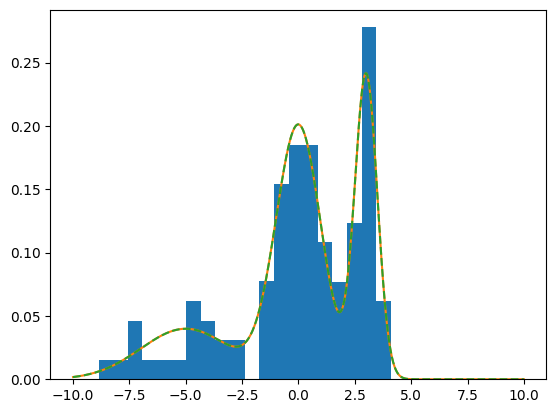

In [68]:
n = 100

key, key_ = jax.random.split(key)
obs = flat_model(true_flat).sample(key_, (n,))
plt.hist(obs, bins=20, density=True)

x = jnp.linspace(-10, 10, 1_000)
p_flat = jnp.exp(flat_log_prob(true_flat)(x))
p_nested = jnp.exp(nested_log_prob(*true_nested)(x))
plt.plot(x, p_flat)
plt.plot(x, p_nested, ls='--');

In [69]:
def forward_nested(obs):
    f0 = numpyro.sample('f0', numpyro.distributions.Uniform(0, 1))
    f1 = numpyro.sample('f1', numpyro.distributions.Uniform(0, 1))
    numpyro.factor('log_lkl', nested_log_prob(f0, f1)(obs).sum())

In [70]:
def forward_flat(obs, concentration=0.5):
    probs = numpyro.sample(
        'probs',
        numpyro.distributions.Dirichlet(concentration * jnp.ones(3)),
        )
    numpyro.factor('log_lkl', flat_log_prob(probs)(obs).sum())

In [71]:
def sampler(key, obs, model, num_warmup=1_000, num_samples=1_000, **args):
    nuts = numpyro.infer.NUTS(model)
    mcmc = numpyro.infer.MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples)
    key, key_ = jax.random.split(key)
    mcmc.run(key_, obs, *args)
    mcmc.print_summary()
    return key, mcmc.get_samples()

In [72]:
key, obs_nested_from_nested = sampler(key, obs, forward_nested)

sample: 100%|████████| 2000/2000 [00:02<00:00, 883.65it/s, 3 steps of size 8.54e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        f0      0.50      0.05      0.50      0.42      0.58   1145.82      1.00
        f1      0.61      0.07      0.61      0.50      0.72    669.57      1.00

Number of divergences: 0


In [73]:
obs_nested_from_nested = np.array(list(obs_nested_from_nested.values()))
obs_flat_from_nested = np.array(nested_to_flat(*obs_nested_from_nested))

In [74]:
key, obs_flat_from_flat = sampler(key, obs, forward_flat)

sample: 100%|████████| 2000/2000 [00:02<00:00, 854.45it/s, 3 steps of size 9.02e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  probs[0]      0.49      0.05      0.49      0.40      0.57   1002.29      1.00
  probs[1]      0.31      0.05      0.31      0.24      0.38    943.86      1.00
  probs[2]      0.20      0.04      0.19      0.13      0.26   1162.33      1.00

Number of divergences: 0


In [75]:
obs_flat_from_flat = np.array(obs_flat_from_flat['probs']).T
obs_nested_from_flat = np.array(flat_to_nested(obs_flat_from_flat))

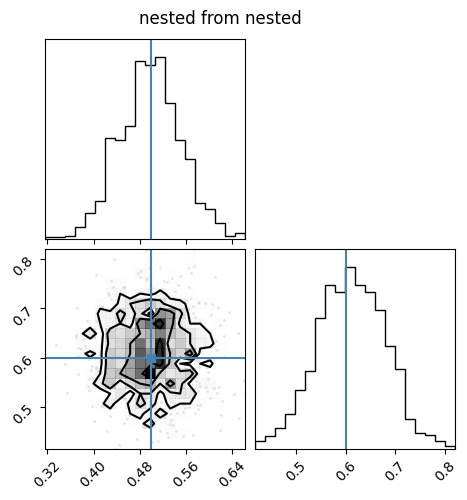

In [76]:
corner(obs_nested_from_nested.T, truths=true_nested)
plt.suptitle('nested from nested');

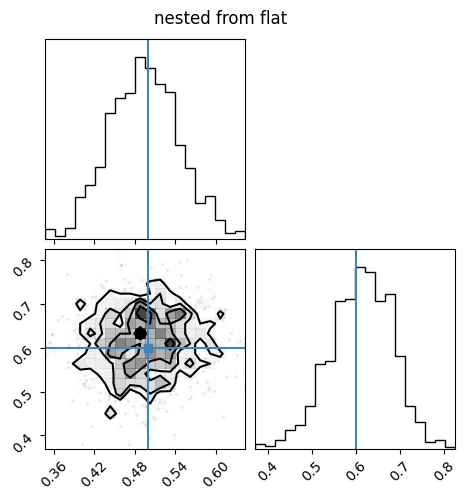

In [77]:
corner(obs_nested_from_flat.T, truths=true_nested)
plt.suptitle('nested from flat');

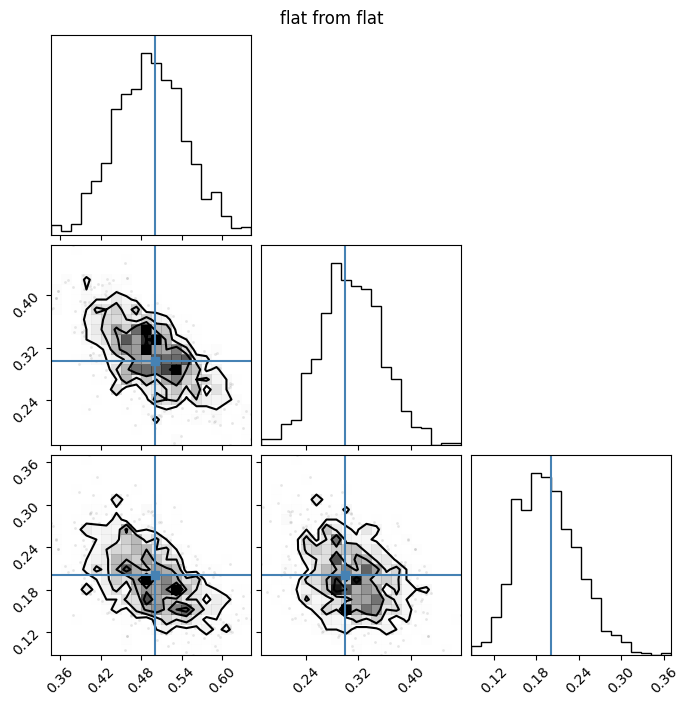

In [78]:
corner(obs_flat_from_flat.T, truths=true_flat)
plt.suptitle('flat from flat');

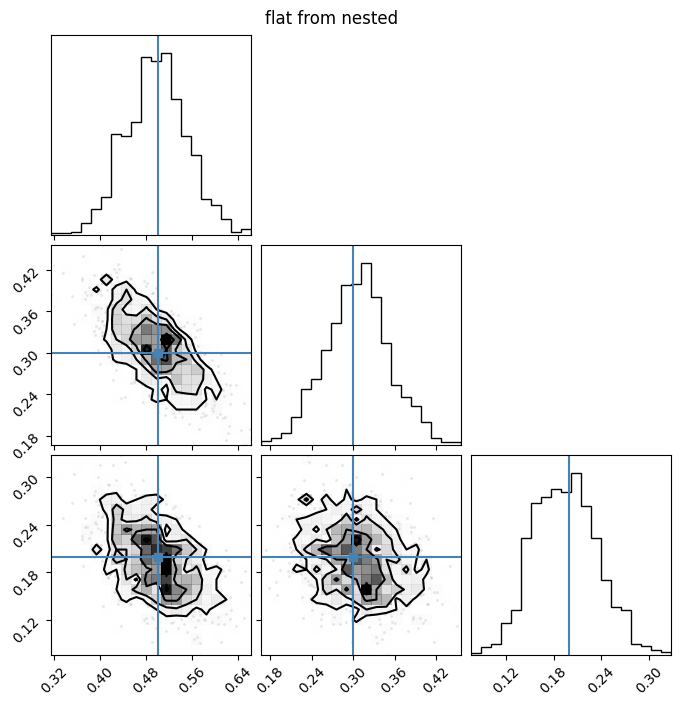

In [79]:
corner(obs_flat_from_nested.T, truths=true_flat)
plt.suptitle('flat from nested');